In [1]:
# =============================================================
# 📦 Cell 1 – Imports
# =============================================================
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator, load_img, img_to_array
)
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import plot_model
import numpy as np, matplotlib.pyplot as plt, seaborn as sns, os, random
from sklearn.metrics import confusion_matrix, classification_report


2025-06-15 16:44:05.225074: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750005845.400602      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750005845.455928      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# =============================================================
# 📂 Cell 2 – Paths & Hyper‑parameters
# =============================================================
base_dir   = '/kaggle/input/maize-leaf-dataset/split_dataset'   # adjust as needed
img_size   = (299, 299)    # InceptionV3 default
batch_size = 32
epochs     = 20            # fast transfer‑learning run

train_path = os.path.join(base_dir, 'train')
val_path   = os.path.join(base_dir, 'val')
test_path  = os.path.join(base_dir, 'test')


In [3]:
# =============================================================
# 🌀 Cell 3 – Data Generators
# =============================================================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30, width_shift_range=0.2, height_shift_range=0.2,
    zoom_range=0.25, horizontal_flip=True, brightness_range=[0.7,1.3])

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_path, target_size=img_size, batch_size=batch_size,
    class_mode='categorical')

val_gen = val_test_datagen.flow_from_directory(
    val_path, target_size=img_size, batch_size=batch_size,
    class_mode='categorical')

test_gen = val_test_datagen.flow_from_directory(
    test_path, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', shuffle=False)


Found 4141 images belonging to 4 classes.
Found 516 images belonging to 4 classes.
Found 522 images belonging to 4 classes.


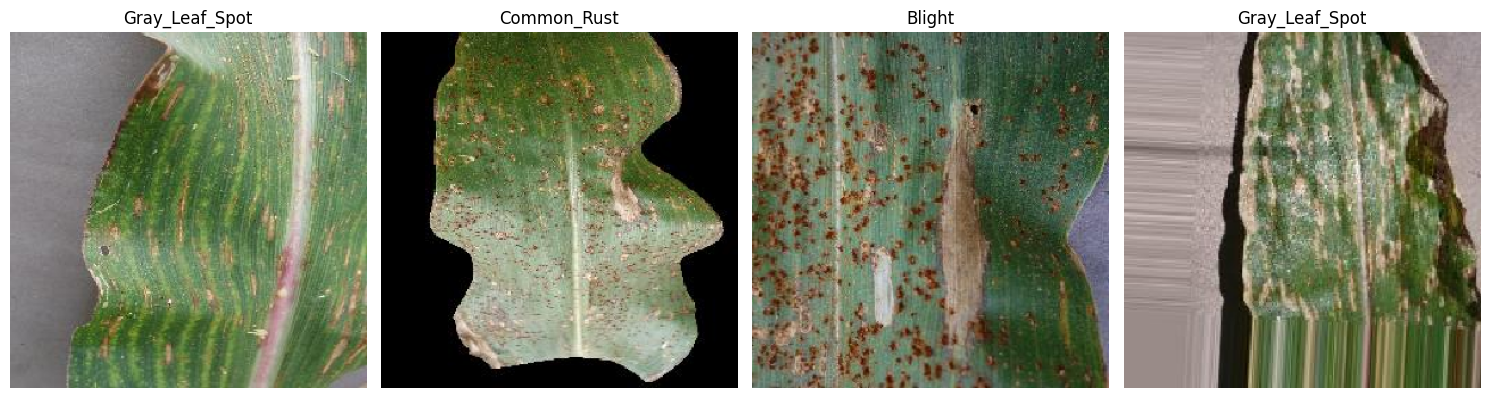

In [4]:
# =============================================================
# 🖼️ Cell 4 – Show Random Images
# =============================================================
def show_random(folder, n=4):
    classes = [c for c in os.listdir(folder) if os.path.isdir(os.path.join(folder, c))]
    plt.figure(figsize=(15,4))
    for i in range(n):
        cls = random.choice(classes)
        file = random.choice(os.listdir(os.path.join(folder, cls)))
        img = load_img(os.path.join(folder, cls, file), target_size=img_size)
        plt.subplot(1,n,i+1); plt.imshow(img); plt.title(cls); plt.axis('off')
    plt.tight_layout(); plt.show()

show_random(train_path)


In [5]:
# =============================================================
# 🧠 Cell 5 – Build Inception V3 Transfer‑Learning Model
# =============================================================
base_model = InceptionV3(include_top=False, weights='imagenet',
                         input_shape=img_size + (3,))
base_model.trainable = False   # freeze

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(train_gen.num_classes, activation='softmax')(x)

model = models.Model(base_model.input, outputs, name='InceptionV3_TL')

model.compile(optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


I0000 00:00:1750005862.951625      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "InceptionV3_TL"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 149, 149, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 149, 149, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 147, 147, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 147, 147, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 147, 147, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 147, 147, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 73, 73, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 73, 73, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 73, 73, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 71, 71, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 71, 71, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 22,328,356 (85.18 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

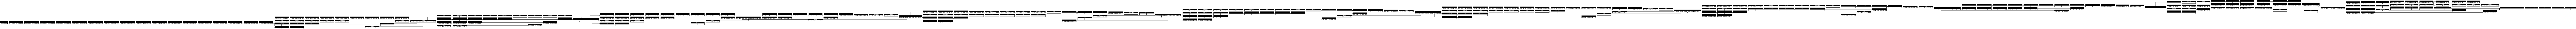

In [6]:
# =============================================================
# 🖨️ Cell 6 – Summary & Architecture Diagram
# =============================================================
model.summary()
plot_model(model, to_file='inceptionv3_arch.png',
           show_shapes=True, rankdir='LR')  # Horizontal
from IPython.display import Image; Image('inceptionv3_arch.png')


In [7]:
# =============================================================
# 🚂 Cell 7 – Train
# =============================================================
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=epochs)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1750005887.417007     120 service.cc:148] XLA service 0x7e92d445b010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750005887.417810     120 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750005889.366660     120 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/130 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.3281 - loss: 1.5187 

I0000 00:00:1750005897.187607     120 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


130/130 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.6096 - loss: 0.9521 - val_accuracy: 0.8140 - val_loss: 0.4606
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 99s 763ms/step - accuracy: 0.8535 - loss: 0.4046 - val_accuracy: 0.8488 - val_loss: 0.3757
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 103s 789ms/step - accuracy: 0.8712 - loss: 0.3382 - val_accuracy: 0.8605 - val_loss: 0.3331
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 101s 779ms/step - accuracy: 0.8884 - loss: 0.2968 - val_accuracy: 0.8353 - val_loss: 0.3815
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 101s 777ms/step - accuracy: 0.9053 - loss: 0.2643 - val_accuracy: 0.8818 - val_loss: 0.2830
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 101s 773ms/step - accuracy: 0.8862 - loss: 0.2813 - val_accuracy: 0.8857 - val_loss: 0.2730
Epoch 7/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 101s 778ms/step - accuracy: 0.8978 - loss: 0.2666 - val_accuracy: 0.8721 - val_loss: 0.3009
Epoch 8/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 100s 772ms/step - accuracy: 0.8951 - loss: 0.2563 -

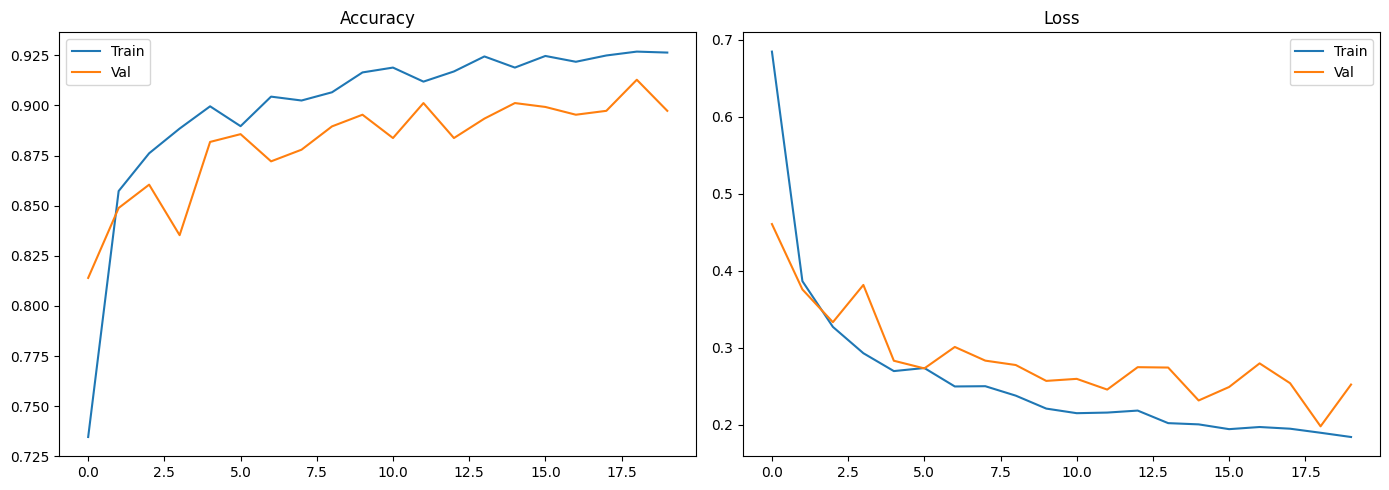

In [8]:
# =============================================================
# 📈 Cell 8 – Plot Accuracy & Loss
# =============================================================
def plot_history(hist):
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(hist.history['accuracy'], label='Train')
    plt.plot(hist.history['val_accuracy'], label='Val')
    plt.title('Accuracy'); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(hist.history['loss'], label='Train')
    plt.plot(hist.history['val_loss'], label='Val')
    plt.title('Loss'); plt.legend()
    plt.tight_layout(); plt.show()

plot_history(history)


17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 852ms/step


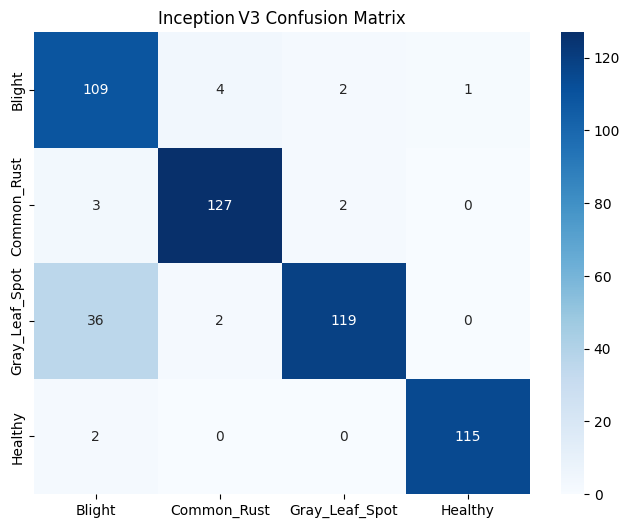

                precision    recall  f1-score   support

        Blight       0.73      0.94      0.82       116
   Common_Rust       0.95      0.96      0.96       132
Gray_Leaf_Spot       0.97      0.76      0.85       157
       Healthy       0.99      0.98      0.99       117

      accuracy                           0.90       522
     macro avg       0.91      0.91      0.90       522
  weighted avg       0.92      0.90      0.90       522



In [9]:
# =============================================================
# 🧮 Cell 9 – Evaluate & Confusion Matrix
# =============================================================
y_pred = model.predict(test_gen)
y_pred_cls = np.argmax(y_pred, axis=1)
y_true = test_gen.classes
labels = list(test_gen.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_cls)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Inception V3 Confusion Matrix'); plt.show()

print(classification_report(y_true, y_pred_cls, target_names=labels))


In [10]:
# =============================================================
# ✅ Cell 10 – Final Train / Val / Test Accuracy
# =============================================================
print(f"Train Accuracy : {history.history['accuracy'][-1]*100:.2f}%")
print(f"Val   Accuracy : {history.history['val_accuracy'][-1]*100:.2f}%")
_, test_acc = model.evaluate(test_gen)
print(f"Test  Accuracy : {test_acc*100:.2f}%")


Train Accuracy : 92.63%
Val   Accuracy : 89.73%
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 325ms/step - accuracy: 0.9059 - loss: 0.2335
Test  Accuracy : 90.04%



Class: Blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


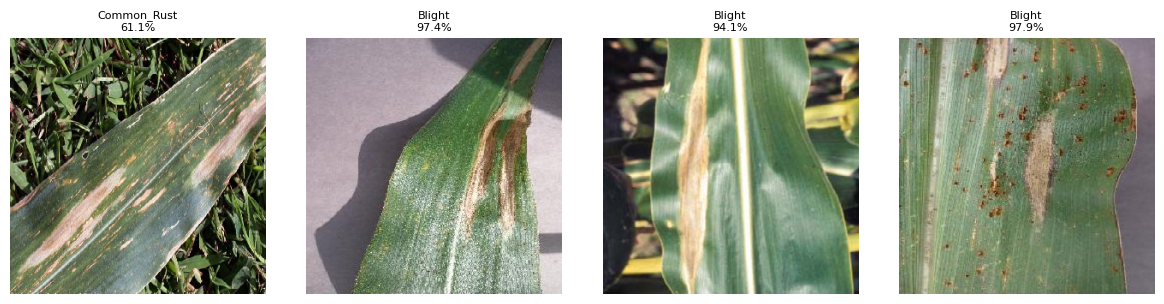


Class: Common_Rust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


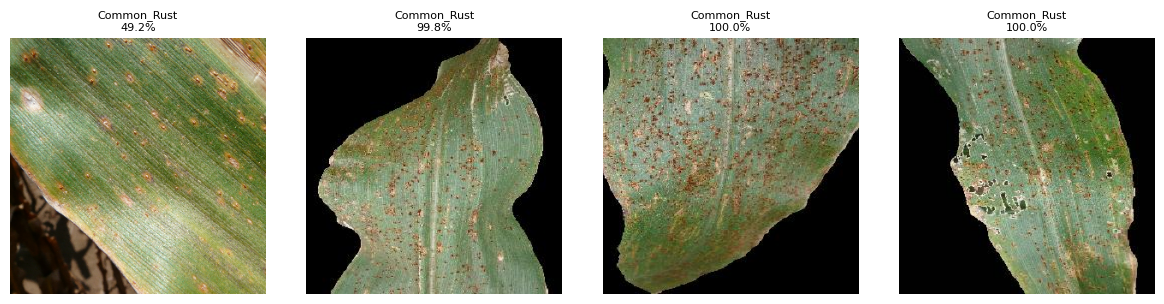


Class: Gray_Leaf_Spot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


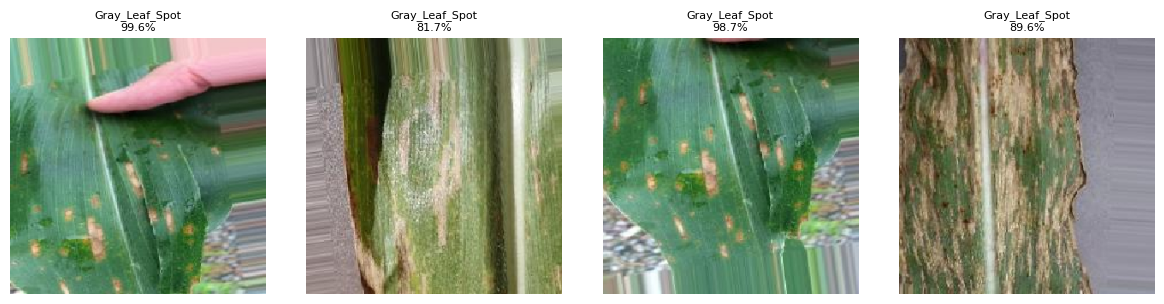


Class: Healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


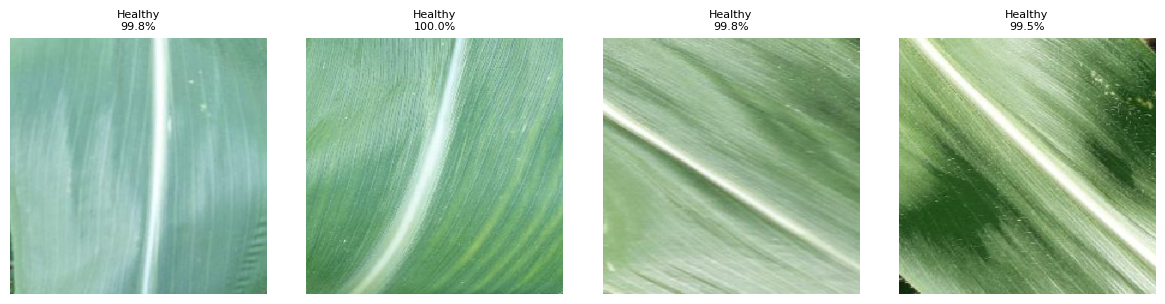

In [11]:
# =============================================================
# 🔍 Cell 11 – Predict Random Test Images
# =============================================================
for cls in labels:
    cls_path = os.path.join(test_path, cls)
    imgs = random.sample(
        [f for f in os.listdir(cls_path) if f.lower().endswith(('jpg','jpeg','png'))], 4)
    print(f"\nClass: {cls}")
    plt.figure(figsize=(12,3))
    for i, img_f in enumerate(imgs):
        p = os.path.join(cls_path, img_f)
        img = load_img(p, target_size=img_size)
        arr = img_to_array(img)/255.0
        pred = model.predict(np.expand_dims(arr,0))
        pred_cls = labels[np.argmax(pred)]
        conf = np.max(pred)*100
        plt.subplot(1,4,i+1)
        plt.imshow(img); plt.axis('off')
        plt.title(f'{pred_cls}\n{conf:.1f}%', fontsize=8)
    plt.tight_layout(); plt.show()


In [12]:
# 💾 Cell 12 – Save the trained model
# =============================================================
model.save("inceptionv3_maize.keras")